# Project Proposal

### Introduction

Scientific Question: Does the patient have heart disease or not based on the following factors: age, blood pressure, cholesterol and chest pain type?

This project aims to use a machine learning algorithm to predict whether or not a patient has heart disease based on age, blood pressure, cholesterol levels, and chest pain type and its degree of accuracy. We will be training the model based on the dataset from https://archive.ics.uci.edu/dataset/45/heart+disease. The dataset includes 13 variables from 4 different database (cleveland.csv, switzerland.csv, long-beach_va.csv and hungarian.csv) that can help our model better identify whether or not a patient is experiencing heart disease which is determined by angiographic narrowing (narrowing of coronary arteries, which are responsible for supplying blood to the heart) being greater than 50%. For example, greater than 50% angiographic narrowing indicates that the patient has heart disease while less than 50% angiographic narrowing indicates that the patient does not have heart disease.

### Preliminary Exploratory Data Analysis
Note that we have imported and built up the data frame and some function in the Jupyter notebook, here are our steps:

**Reading Data**

We directly used the function read_csv with the URL of the data frame (already tidy) on the website, and used write_csv or write_tsv to store the data. 

By combining all 4 data frames from different countries with r_bind, we get a full data frame including all cases. 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

colnames1 <- c("index", "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
              "slope", "ca", "thal", "num")

colnames2 <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
              "slope", "ca", "thal", "num")

# Reading in the data
cleveland_raw <- read_csv("data/cleveland.csv", col_name = colnames1, , skip = 1)
switzerland_raw <- read_csv("data/switzerland.csv", col_name = colnames1, , skip = 1)
va_raw <- read_csv("data/va_longbeach.csv", col_name = colnames1, , skip = 1)
hungary <- read_csv("data/hungary.csv", col_name = colnames2, skip = 1)


# Selecting the data without the index
cleveland <- select(cleveland_raw, -index)
switzerland <- select(switzerland_raw, -index)
va <- select(va_raw, -index)


# Filtering out the aggregated databases for bad data points
database_raw <- rbind(cleveland, switzerland, va, hungary)
database <- database_raw |>
            filter(age != "?") |>
            filter(sex != "?") |>
            filter(cp != "?") |>
            filter(trestbps != "?") |>
            filter(chol != "?") |>
            filter(fbs != "?") |>
            filter(restecg != "?") |>
            filter(thalach != "?") |>
            filter(exang != "?") |>
            filter(oldpeak != "?") |>
            filter(slope != "?") |>
            filter(ca != "?") |>
            filter(thal != "?") |>
            filter(num != "?") |>
            filter(exang != -9) |>
            filter(fbs != -9) |>
            filter(slope != -9) |>
            filter(ca != -9) |>
            filter(ca != 9) |>
            filter(num != 2) |>
            filter(num != 3) |>
            filter(num != 4) |>
            mutate_if(is.character, as.numeric)|>
            mutate(scaled_trestbps=scale(trestbps,center=TRUE),
                   scaled_chol=scale(chol,center=TRUE))

# Totally, there are 5 data frames:
# 1. cleveland
# 2. switzerland
# 3. va
# 4. hungary
# 5. database
head(database)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,scaled_trestbps,scaled_chol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>"
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,0.87288500,-0.2164629
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,-0.60704561,-0.2940340
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,-0.01507337,0.1132143
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0,-0.01507337,-0.7788533
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0,-0.60704561,-0.1582845
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0,-0.60704561,2.1300628


**Summarizing data**

The training and testing data are splitted with a proportion of 0.75 and 0.25 from the data frame. Three tables are concluded to summarize the data:

count_age and count_cp, which counts the number of people with different ages and different chest pain types. These 2 tables reflect that we have enough data points from these two groups.

group_mean, which summarizes the mean value across all 4 variables we want to analyze. This table gives a standardized level we can use to compare with our outcomes.



In [2]:
# splitting data into training data and testing data
database_split<-initial_split(database, prop = 0.75,strata = num)
database_train<-training(database_split)
database_test<-testing(database_split)

# count the number of patients with different ages
count_age <- database_train |>
             group_by(age) |>
             summarize(count = n())
count_age

# count the number of patients with different types of chest pain
count_cp <- database_train |>
             group_by(cp) |>
             summarize(count = n())
count_cp

#count the average value of variables
group_mean <- database_train |>
              summarize(across(age:num, mean, na.rm = TRUE)) |>
              select(age, cp, trestbps, chol)
group_mean

age,count
<dbl>,<int>
29,1
34,1
35,4
39,3
40,2
41,7
42,6
43,2
44,7


cp,count
<dbl>,<int>
1,16
2,39
3,56
4,51


age,cp,trestbps,chol
<dbl>,<dbl>,<dbl>,<dbl>
53.40741,2.876543,130.5123,245.8889


**Visualizing data**

Two side by side bar plots each representing a sex group (0 = female, 1 = male), and contains two bars (diagnosis) and the corresponding proportion of people with each chest pain type (indicated with different colors). This plot shows a pattern that the proportion of people (both male or female) with chest pain type 4 (asymptomatic) is significantly larger if they are diagnosed to have heart disease. It is strange that most people with heart disease have no symptoms. 

Two side by side scatter plots each representing a sex group (0 = female, 1 = male), and contains points describing the relationship between serum cholesterol level among people with different ages, and their diagnosis (indicated with 2 colors). From the scatter plot, we can observe that heart disease is more prevalent among males than females. For both sexes, there is no relationship between cholesterol and age as the points are randomly scattered. However, we can observe that as age increases, the chances of having heart disease also increases although there is a weak correlation. 


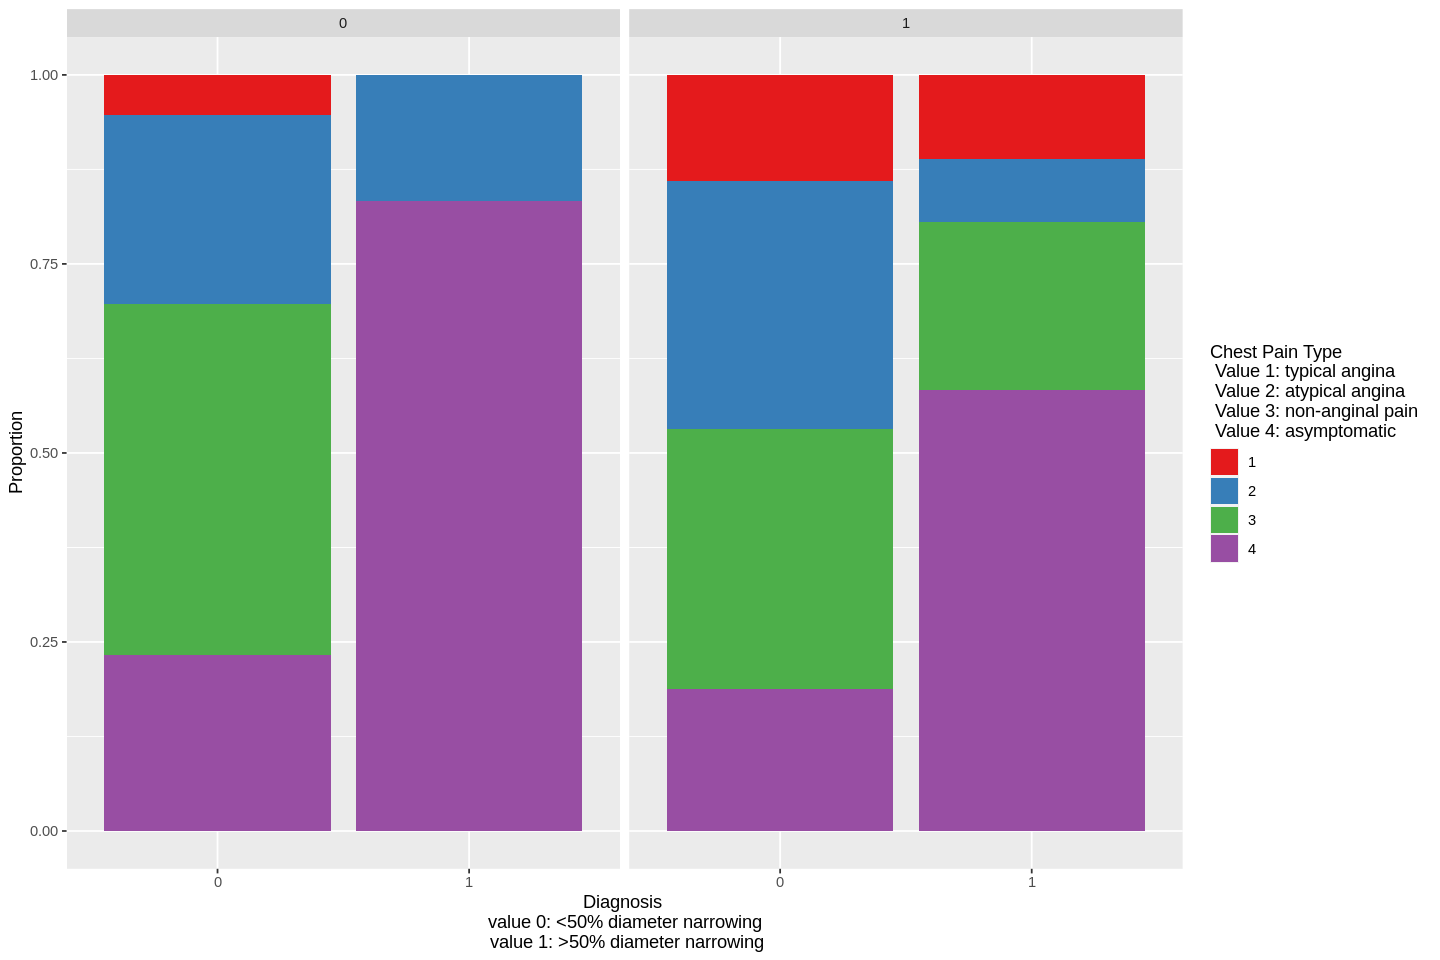

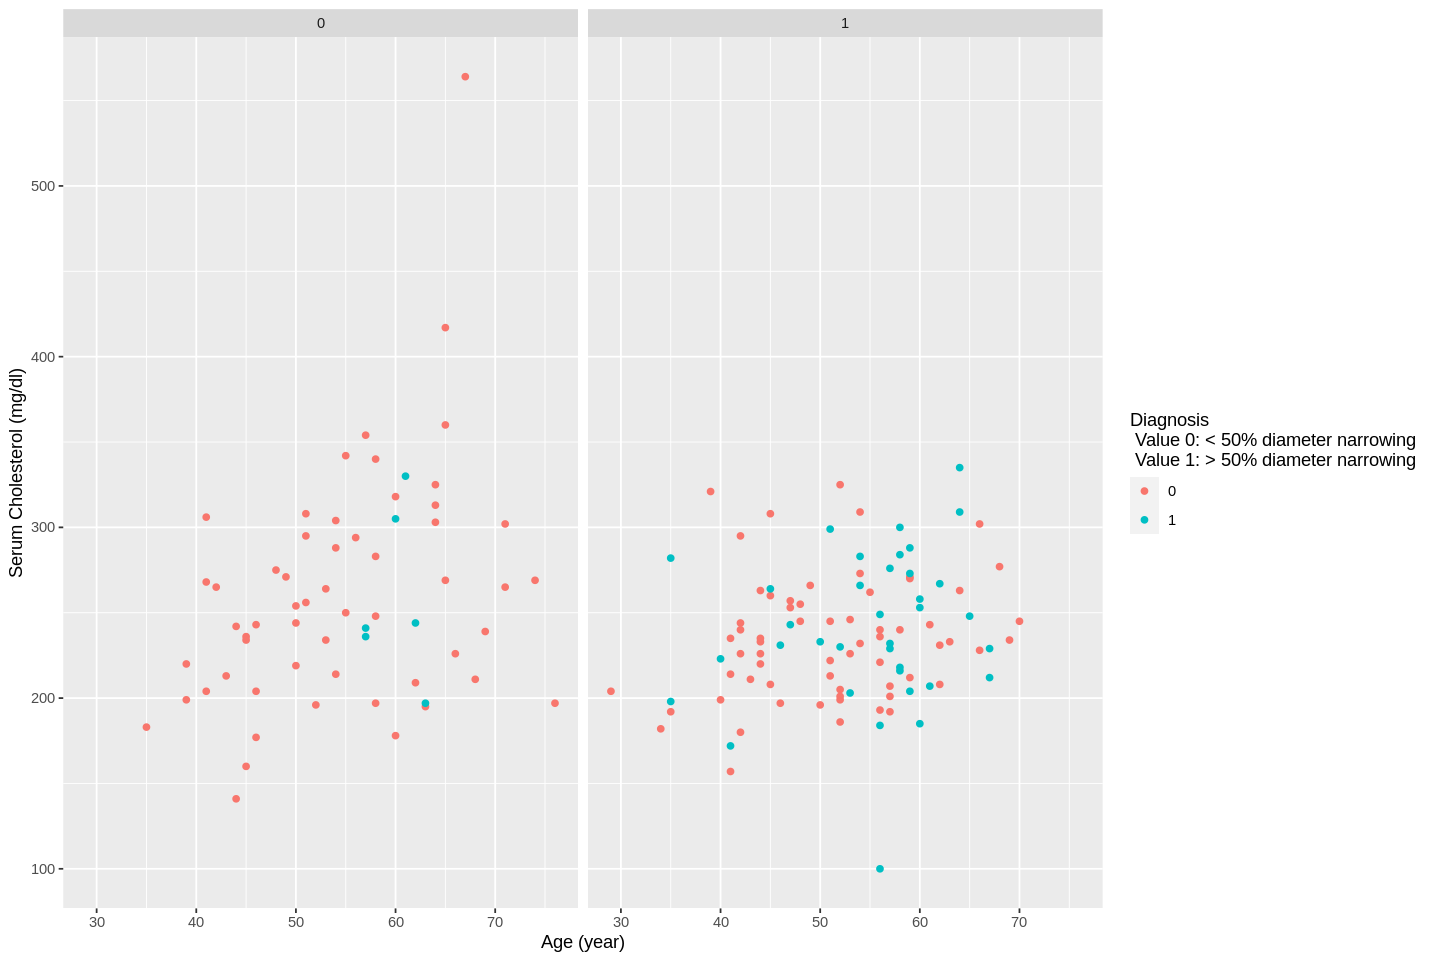

In [3]:
options(repr.plot.width = 12, repr.plot.height = 8)
# plotting with bar plot
cp_num_plot <- database_train |>
    ggplot(aes(x = as_factor(num), fill = as_factor(cp))) + 
    geom_bar(position = 'fill') +
    xlab('Diagnosis \n value 0: <50% diameter narrowing \n value 1: >50% diameter narrowing') +
    ylab('Proportion') +
    labs(fill = "Chest Pain Type \n Value 1: typical angina \n Value 2: atypical angina \n Value 3: non-anginal pain \n Value 4: asymptomatic") +
    facet_grid(cols = vars(sex)) +
    scale_fill_brewer(palette = "Set1")
cp_num_plot

# plotting with scatter plot
age_chol_plot <- database_train |>
    ggplot(aes(x = age, y = chol, color = as_factor(num))) + 
    geom_point() +
    xlab('Age (year)') +
    ylab('Serum Cholesterol (mg/dl)') +
    labs(color = "Diagnosis \n Value 0: < 50% diameter narrowing \n Value 1: > 50% diameter narrowing") +
    facet_grid(cols = vars(sex))
age_chol_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6424242,5,0.028862543,Preprocessor1_Model01
2,accuracy,binary,0.6424242,5,0.028862543,Preprocessor1_Model02
3,accuracy,binary,0.6729167,5,0.015309311,Preprocessor1_Model03
4,accuracy,binary,0.6729167,5,0.015309311,Preprocessor1_Model04
5,accuracy,binary,0.6731061,5,0.025979437,Preprocessor1_Model05
6,accuracy,binary,0.6731061,5,0.025979437,Preprocessor1_Model06
7,accuracy,binary,0.6852273,5,0.037154052,Preprocessor1_Model07
8,accuracy,binary,0.6852273,5,0.037154052,Preprocessor1_Model08
9,accuracy,binary,0.7346591,5,0.015393429,Preprocessor1_Model09


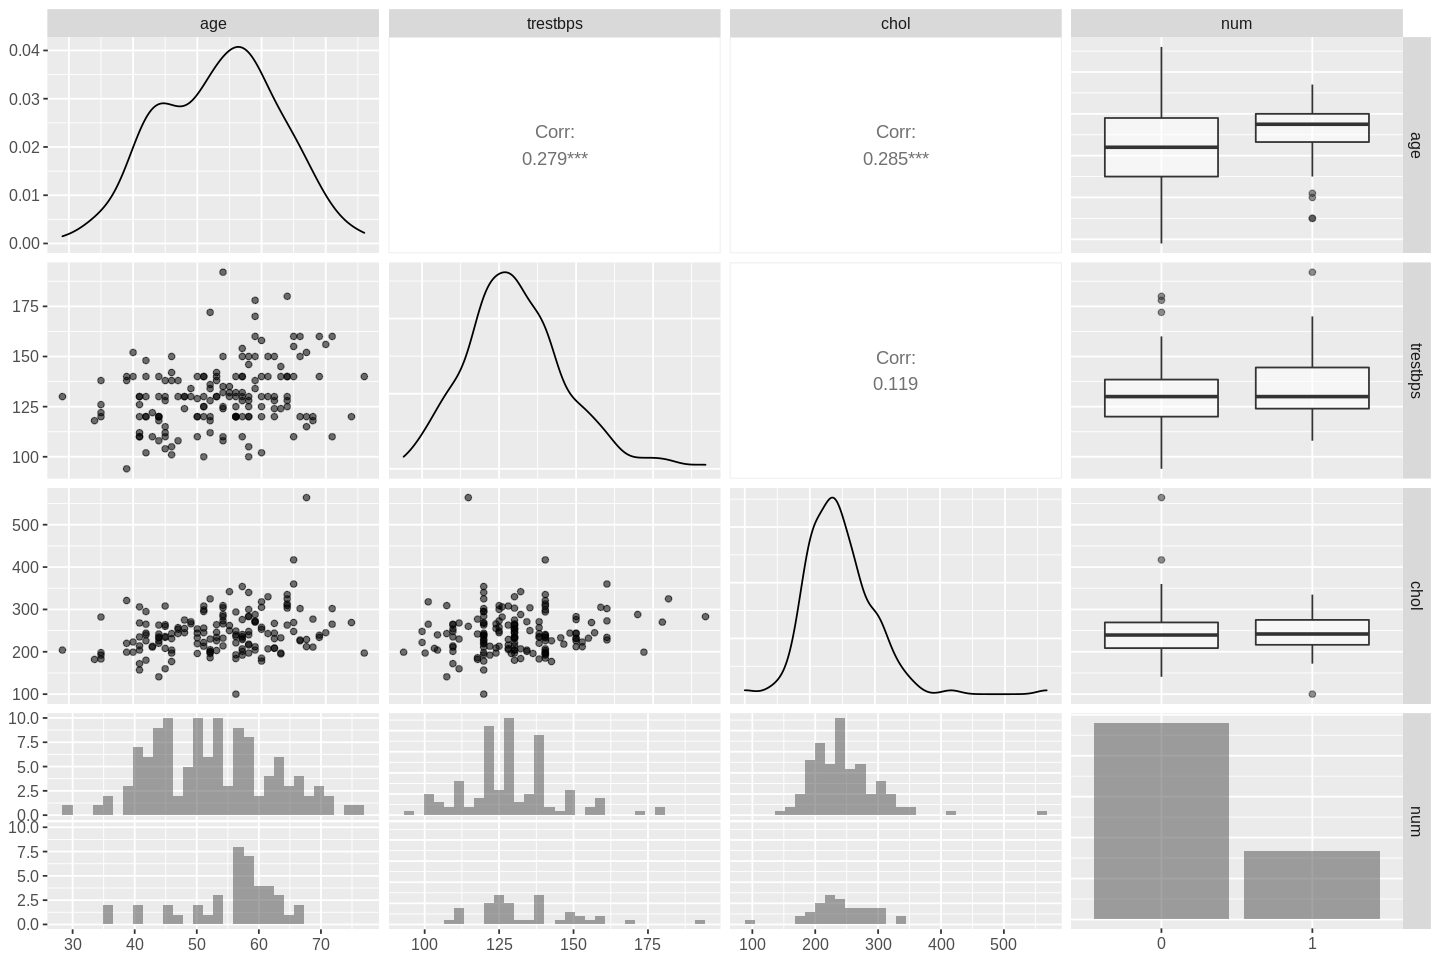

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,scaled_trestbps,scaled_chol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>"
1,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,-0.01507337,0.11321430
2,57,1,3,150,168,0,0,174,0,1.6,1,0,3,0,1.16887112,-1.47699321
1,48,1,2,110,229,0,0,168,0,1.0,3,0,7,1,-1.19901786,-0.29403396
1,54,1,4,140,239,0,0,160,0,1.2,1,0,3,0,0.57689888,-0.10010622
1,64,1,1,110,211,0,2,144,1,1.8,2,0,3,0,-1.19901786,-0.64310391
1,43,1,4,150,247,0,0,171,0,1.5,1,0,3,0,1.16887112,0.05503598
2,59,1,4,135,234,0,0,161,0,0.5,2,0,7,0,0.28091275,-0.19707009
1,51,1,3,110,175,0,0,123,0,0.6,1,0,3,0,-1.19901786,-1.34124379
1,53,1,3,130,197,1,2,152,0,1.2,3,0,3,0,-0.01507337,-0.91460275


ERROR: [1m[33mError[39m in [1m[1m`value[[3L]]()`:[22m
[33m![39m In metric: `accuracy`
[1m[22mProblem while computing `.estimate = metric_fn(truth = num, estimate =
.pred_class, na_rm = na_rm)`.
[1mCaused by error in [1m[1m`binary_checks()`:[22m
[33m![39m `truth` and `estimate` levels must be equivalent.
`truth`: 0, 1
`estimate`: 1, 2


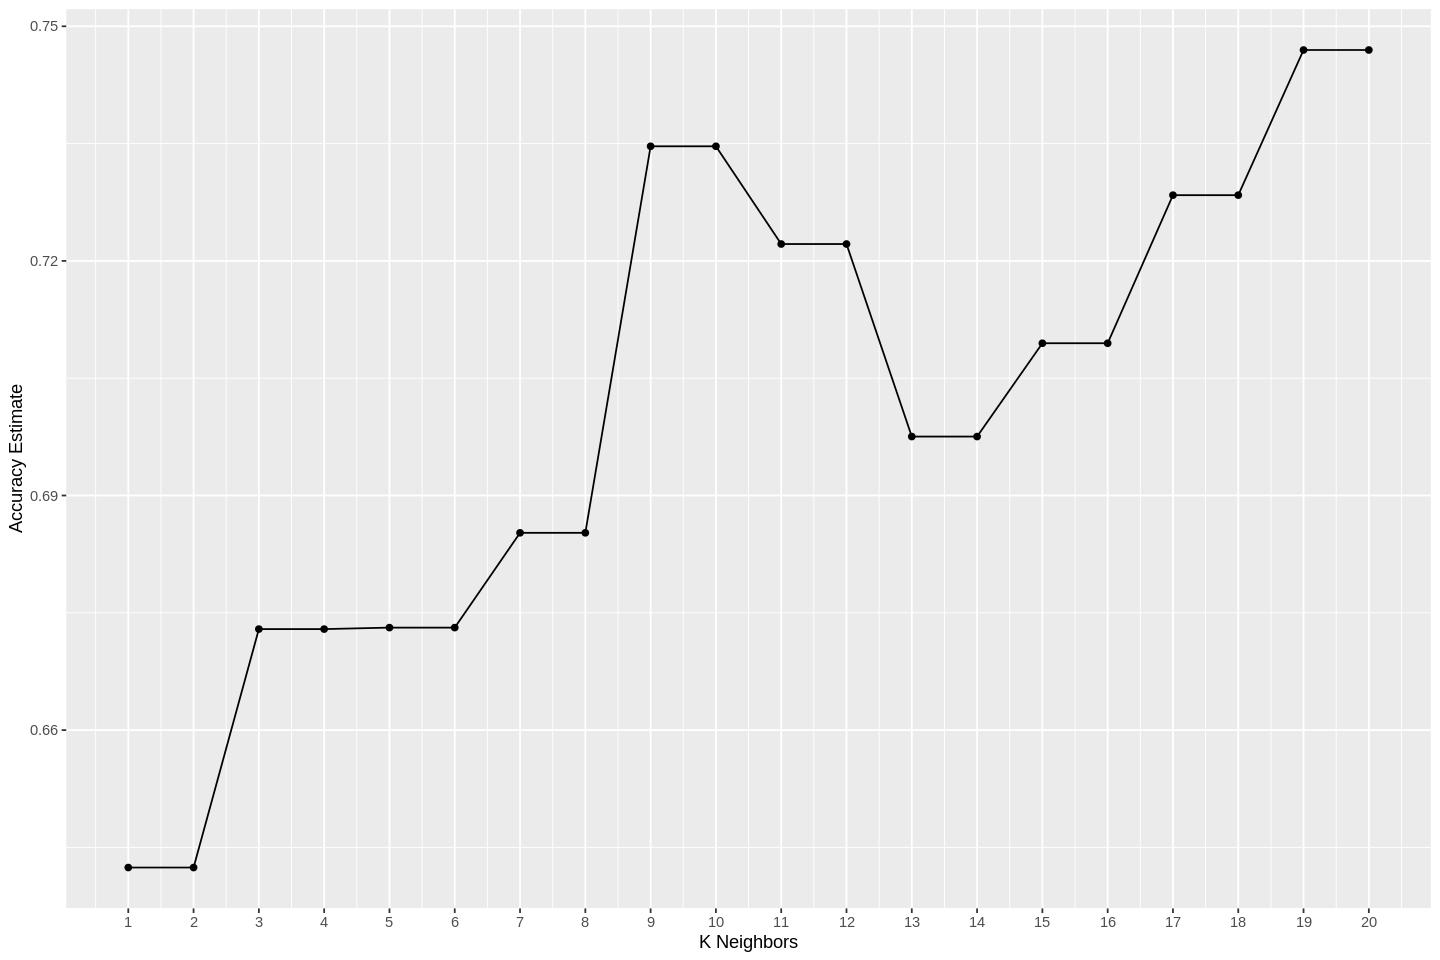

In [6]:
database_train_selected <- select(database_train, age, trestbps, chol, num) |>
                           mutate(num = as_factor(num))

graph <- database_train_selected |>
         ggpairs(mapping = aes(alpha = 0.4)) +
         theme(text = element_text(size = 12))
graph
\
set.seed(1234)
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_recipe <- recipe(num ~ ., data = database_train_selected) |>
     step_scale(all_predictors()) |>
     step_center(all_predictors())

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

data_vfold <- vfold_cv(database_train_selected, v = 5, strata = num)

knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_tune) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

knn_results

k_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
          geom_point() +
          geom_line() +
          labs(x = "K Neighbors", y = "Accuracy Estimate") +
          scale_x_continuous(breaks = seq(0, 20, by = 1))

k_plot

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
           add_recipe(knn_recipe) |>
           add_model(knn_spec) |>
           fit(data = database_train_selected)

prediction <- knn_fit |>
              predict(database_test) |>
              mutate(.pred_class = as.numeric(.pred_class)) |>
              bind_cols(database_test) |>
              mutate(.pred_class = as_factor(.pred_class),
                     num = as_factor(num))
prediction        

predict_metrics <- metrics(prediction, truth = num, estimate = .pred_class)
predict_metrics

predict_conf_mat <- conf_mat(prediction, truth = num, estimate = .pred_class)
predict_conf_mat

### Methods

To simplify calculations, we will only consider age, blood pressure (trestbps), cholesterol (chol) levels and chest pain type (cp) as predictor variables against the angiographic variable of the presence or absence of a >50% diameter narrowing (num). We chose these variables as they were considered “clinically relevant” in regards to the research paper https://doi.org/10.1016/0002-9149(89)90524-92. In terms of visualizing results, we will be making use of scatterplots and barplots in order to view possible correlations between two quantitative variables and adding colors to categorical variables.
The data will be tidied up for better analysis by first reading the dataset into R, then the unprocessable observations will be filtered out. After this, the variables of age, blood pressure, cholesterol levels and chest pain type will be plotted against one another as scatterplots and barplots in order to view the possible correlations between the variables. Lastly a prediction function will be constructed using the training group from our dataset to predict if a patient is experiencing heart disease and then back tested using the testing data to ensure that our model is accurate. 

The data frame we constructed contains 14 columns, we have listed them below. Column names that are bolded are targets to be analyzed.


**1. (age) in years**

2. (sex)

**3. (cp) chest pain type**

**-- Value 1: typical angina**

**-- Value 2: atypical angina**

**-- Value 3: non-anginal pain**

**-- Value 4: asymptomatic**

**4. (trestbps) resting blood pressure (in mm Hg on admission to the hospital) : high blood pressure → higher risk of heart disease**
  
**5. (chol) serum cholesterol in mg/dl : high cholesterol →higher risk of  heart disease**

6. (fbs) (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. (restecg) resting electrocardiographic results
8. (thalach) maximum heart rate achieved
9. (exang) exercise induced angina (1 = yes; 0 = no)
10. (oldpeak) ST depression induced by exercise relative to rest
11. (slope) the slope of the peak exercise ST segment
-- Value 1: upsloping
-- Value 2: flat
-- Value 3: downsloping 
12. (ca) number of major vessels (0-3) colored by flourosopy
13. (thal) 3 = normal; 6 = fixed defect; 7 = reversable defect
14. (num) diagnosis of heart disease (angiographic disease status, predicted)
      -- Value 0: < 50% diameter narrowing
      -- Value 1: > 50% diameter narrowing



### Expected outcomes and significance

We hope that through the model that we have created, we will be able to predict whether or not a patient is suffering from heart disease to a degree of accuracy. This will allow doctors to provide patients with a high likelihood of suffering from heart disease with an accurate diagnosis and an earlier as well as proper treatment for their illness. When initially reading the data, some of it was untidy, missing column names, and needed to be filtered out for missing data points. 

Since we are only given a limited number of variables, we might not be able to construct the predictor and classifier with high precision. In the future, we will consider pulling more data frames and variables from online sources such as symptoms and physical indicators to adapt our classifier model.

### References

1. Janosi, A., Steinbrunn, W,, Pfisterer, M., Detrano,R. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X 

2. Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J., Sandhu, S., Guppy, K., Lee, S., Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery. The American Journal of Cardiology, 64 (5), 304 - 310. https://doi.org/10.1016/0002-9149(89)90524-9

3. https://www.sciencedirect.com/science/article/pii/0002914989905249
